# Imports

In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
import os
import glob
import json
import ast
import re

from typing import Dict, List

from src.parsers.cv_parser import fmt_cv_results
from src.visualizers.prediction_figures import PredictionFigures
from src.visualizers.test_figures import TestFigures
from src.visualizers.cv_figures import CVFigures
from src.settings.strategy import Strategy
from src.settings.tier import Tier

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

In [4]:
metabolite_info = get_metabolite_info()

In [5]:
class ResultFetcher:
    def __init__(self, root_dir: str, metabolite_info: pd.DataFrame) -> None:
        self.root_dir = root_dir
        self.metabolite_info = metabolite_info
    
    def get_all(self, experiment_id: Tier):
        test_df_all = self.get_test_df_all(experiment_id)
        test_df_metabolite = self.get_test_df_metabolite(experiment_id)
        test_df_one_vs_all = self.get_test_df_one_vs_all(experiment_id)
        return test_df_all, test_df_metabolite, test_df_one_vs_all
    
    def get_test_df_all(self, experiment_id: Tier):
        df = self.get_frame(experiment_id, Strategy.ALL)
        df = df.assign(strategy='all').assign(experiment_id=experiment_id)
        return df
    
    def get_test_df_metabolite(self, experiment_id: Tier):
        df = self.get_frame(experiment_id, Strategy.METABOLITE_CENTRIC)
        df = df.assign(strategy='metabolite').assign(experiment_id=experiment_id)
        return df
    
    def get_test_df_one_vs_all(self, experiment_id: Tier):
        df = self.get_frame(experiment_id, Strategy.ONE_VS_ALL)
        df = df.assign(strategy='one_vs_all').assign(experiment_id=experiment_id)
        return df
        
    def get_frame(self, experiment_id: Tier, strategy: Strategy):
        path = f"{self.root_dir}/{experiment_id}/best_model_performance_{strategy}.csv"
        print(path)
        if self.file_exists(path):
            test_df_all = pd.read_csv(path, index_col=0)
            test_df_all = test_df_all.stack().to_frame().reset_index(1).set_axis(['metabolite_arch', 'r2'], axis=1)
            test_df_all[['metabolite_id', 'architecture']] = test_df_all['metabolite_arch'].str.split("_", expand=True)
            test_df_all = test_df_all.drop('metabolite_arch', axis=1).merge(metabolite_info, left_on='metabolite_id', right_index=True)
            return test_df_all
    
    def file_exists(self, path: str):
        return os.path.exists(path)

In [6]:
result_fetcher = ResultFetcher(
    root_dir="/home/tvangraft/tudelft/thesis/metaengineering/data/results",
    metabolite_info=metabolite_info
)

test_df_all = pd.concat([result_fetcher.get_test_df_all(i) for i in [Tier.TIER0, Tier.TIER1]])
test_df_metabolite = pd.concat([result_fetcher.get_test_df_metabolite(i) for i in [Tier.TIER0, Tier.TIER1]])
test_df_one_vs_all = pd.concat([result_fetcher.get_test_df_one_vs_all(i) for i in [Tier.TIER0, Tier.TIER1]])

test_df = pd.concat([test_df_all, test_df_metabolite, test_df_one_vs_all], axis=0)
test_df_arch_all = test_df[test_df['architecture'] == 'all']
test_df_arch_per_model = test_df[test_df['architecture'] != 'all']
test_figures = TestFigures(test_df_arch_all)

/home/tvangraft/tudelft/thesis/metaengineering/data/results/Tier.TIER0/best_model_performance_Strategy.ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/Tier.TIER1/best_model_performance_Strategy.ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/Tier.TIER0/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/Tier.TIER1/best_model_performance_Strategy.METABOLITE_CENTRIC.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/Tier.TIER0/best_model_performance_Strategy.ONE_VS_ALL.csv
/home/tvangraft/tudelft/thesis/metaengineering/data/results/Tier.TIER1/best_model_performance_Strategy.ONE_VS_ALL.csv


# R2 metric

In [7]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
tier_2_results['experiment_id'] = tier_2_results['mode'].apply(lambda x: f"{Tier.TIER2}_{x.replace('metabolite_gnn_sweep_full_', '')}")
tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'r2'}, axis=1)
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'r2', 'metabolite_id']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results = tier_2_results.assign(architecture='all')
tier_2_results

,experiment_id,strategy,r2,metabolite_id,official_name,kegg_id,pathway,method,Order,architecture
0,Tier.TIER2_strict,one_vs_all,0.811178,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
1,Tier.TIER2_strict,one_vs_all,0.701284,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
2,Tier.TIER2_strict,one_vs_all,0.835975,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
3,Tier.TIER2_strict,one_vs_all,0.893891,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
4,Tier.TIER2_strict,one_vs_all,0.812117,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
...,...,...,...,...,...,...,...,...,...,...
1099,Tier.TIER2_all,all,-0.047612,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
1100,Tier.TIER2_all,all,0.450446,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
1101,Tier.TIER2_all,all,0.105881,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
1102,Tier.TIER2_all,all,0.000000,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all


In [8]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
tier_2_results['experiment_id'] = tier_2_results['mode'].apply(lambda x: f"{Tier.TIER2}_{x.replace('metabolite_gnn_sweep_full_', '')}")
tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'r2'}, axis=1)
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'r2', 'metabolite_id']]
tier_2_results = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['r2'].transform(max) == tier_2_results['r2']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results = tier_2_results.assign(architecture='all')
tier_2_results

,experiment_id,strategy,r2,metabolite_id,official_name,kegg_id,pathway,method,Order,architecture
13,Tier.TIER2_strict,one_vs_all,0.942396,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
187,Tier.TIER2_all,one_vs_all,0.893907,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
306,Tier.TIER2_unfiltered,metabolite,0.272850,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
466,Tier.TIER2_strict,metabolite,0.105441,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
647,Tier.TIER2_all,metabolite,0.491592,f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,all
...,...,...,...,...,...,...,...,...,...,...
166,Tier.TIER2_all,one_vs_all,0.754175,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
450,Tier.TIER2_strict,metabolite,0.268139,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
624,Tier.TIER2_all,metabolite,0.301719,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all
927,Tier.TIER2_strict,all,0.301429,pep,Phosphoenolpyruvate,C00074,Glycolysis,TCA,7,all


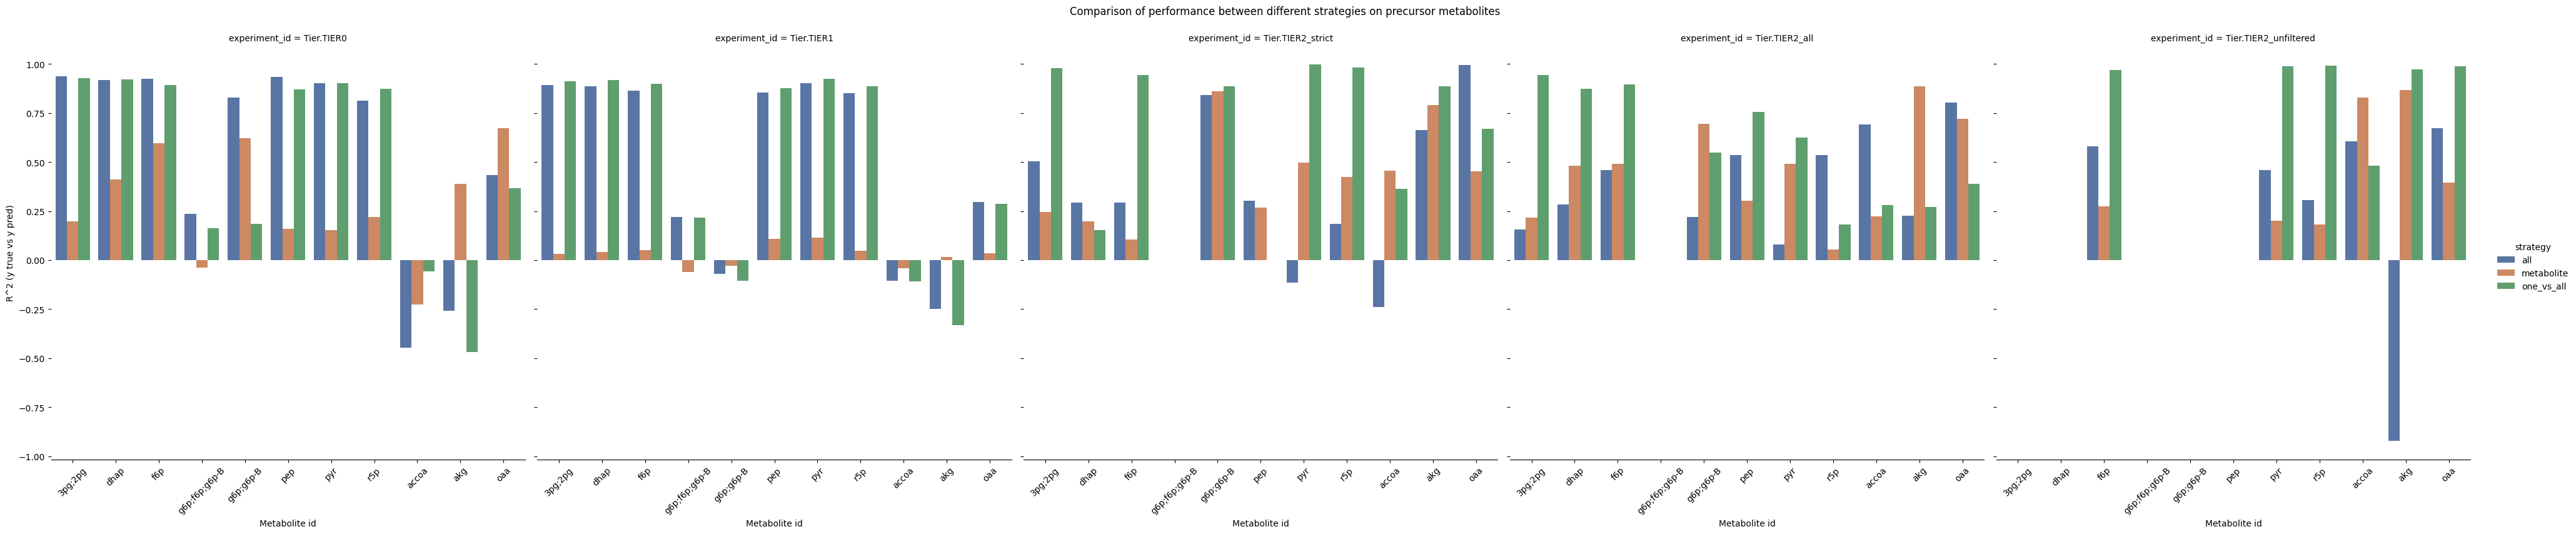

In [9]:
_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id']).reset_index(drop=True)
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0)
g = sns.catplot(
    data=_df, 
    col='experiment_id',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='strategy',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

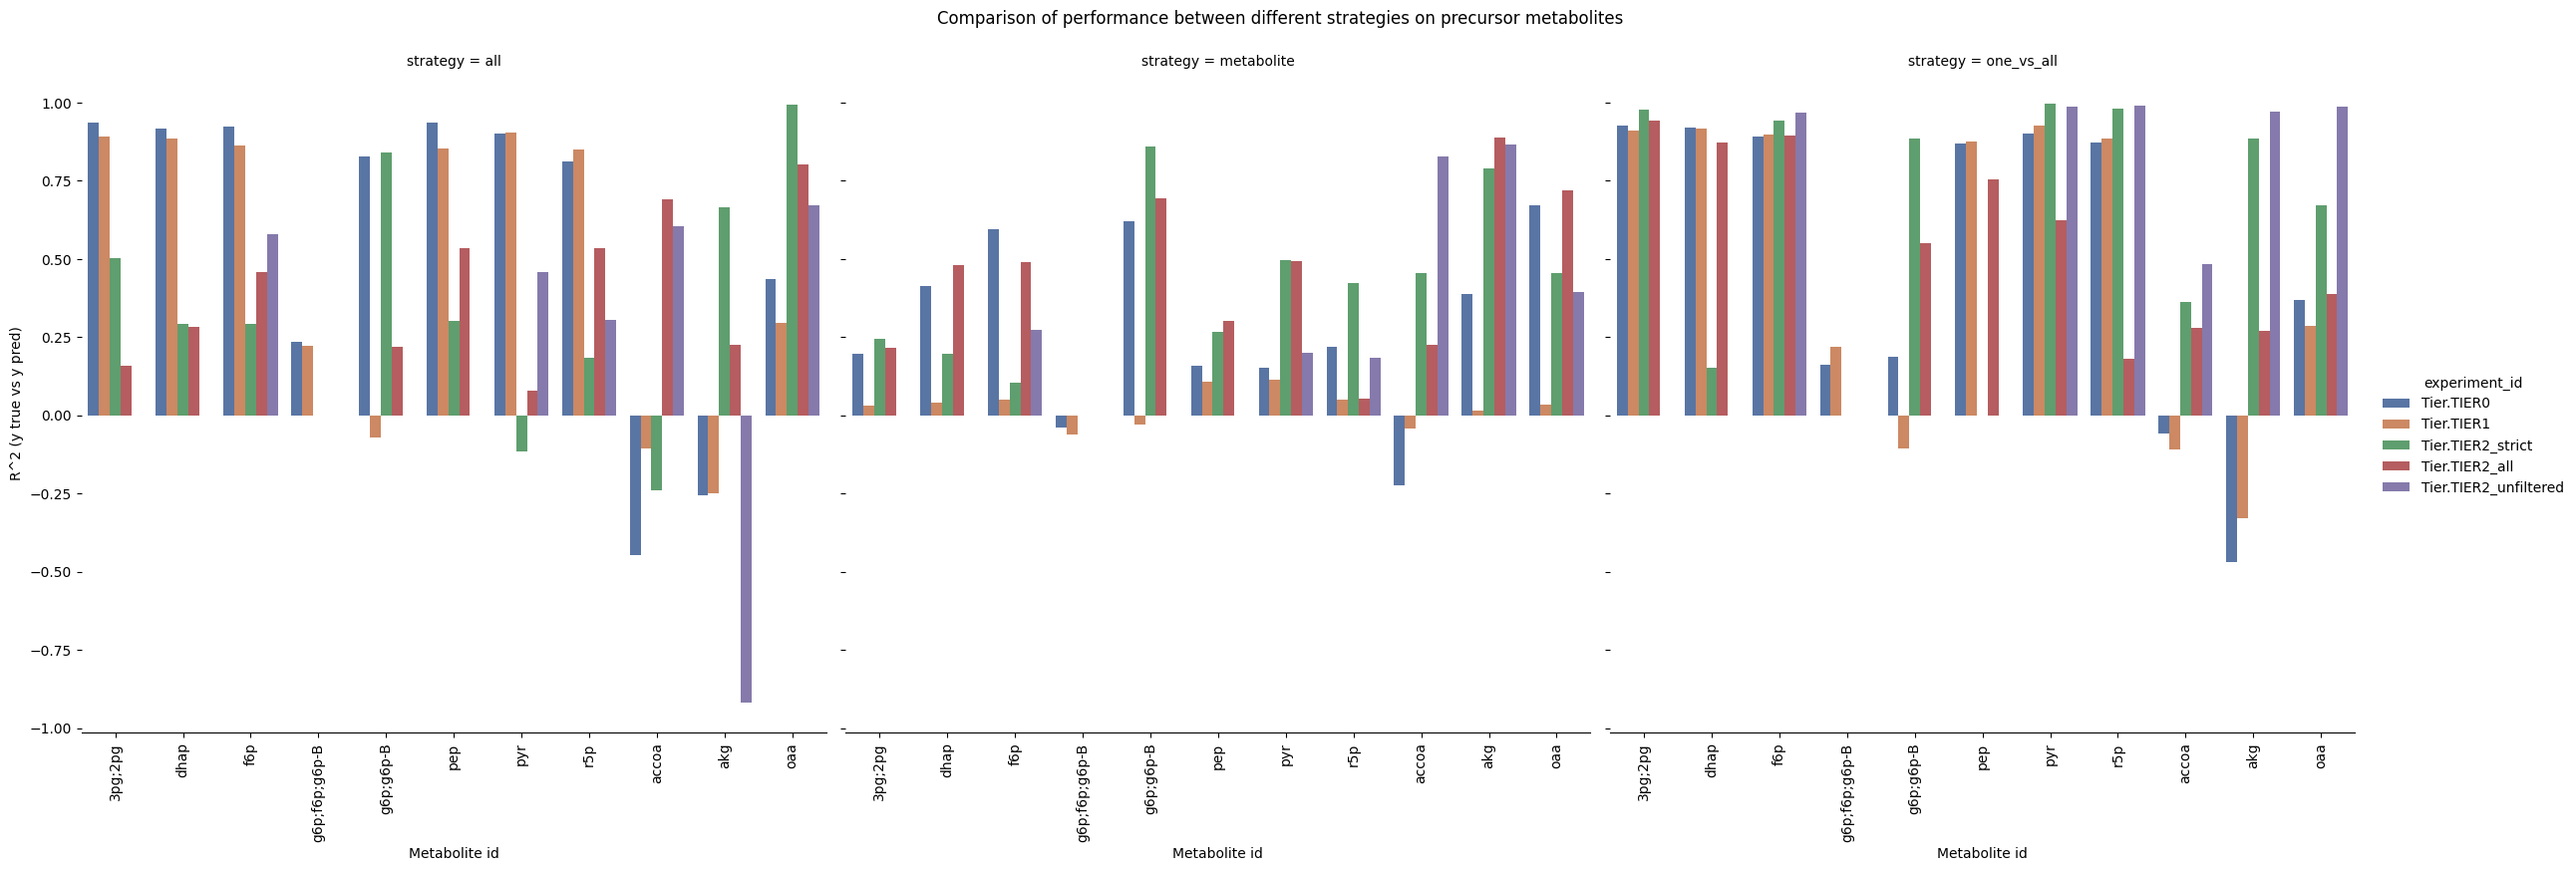

In [10]:
_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0)
g = sns.catplot(
    data=_df, 
    col='strategy',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='experiment_id',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

AttributeError: PathCollection.set() got an unexpected keyword argument 'style'

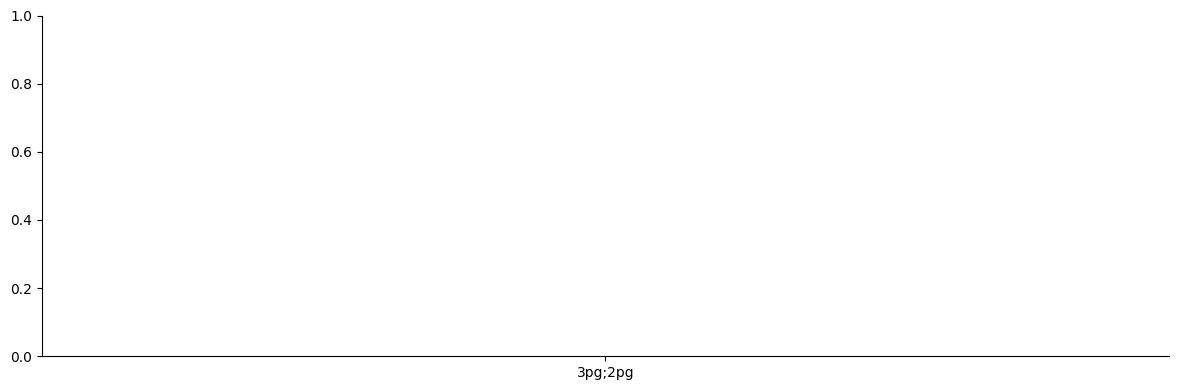

In [11]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
tier_2_results['experiment_id'] = tier_2_results['mode'].apply(lambda x: f"{Tier.TIER2}")
tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'r2'}, axis=1)
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'r2', 'metabolite_id']]
tier_2_results = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['r2'].transform(max) == tier_2_results['r2']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results = tier_2_results.assign(architecture='all')

_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0).reset_index(drop=True)
g = sns.catplot(
    data=_df, 
    style='strategy',
    kind='strip',
    x='metabolite_id',
    y='r2',
    hue='experiment_id',
    palette='deep',
    height=4,
    aspect=3,
    size=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

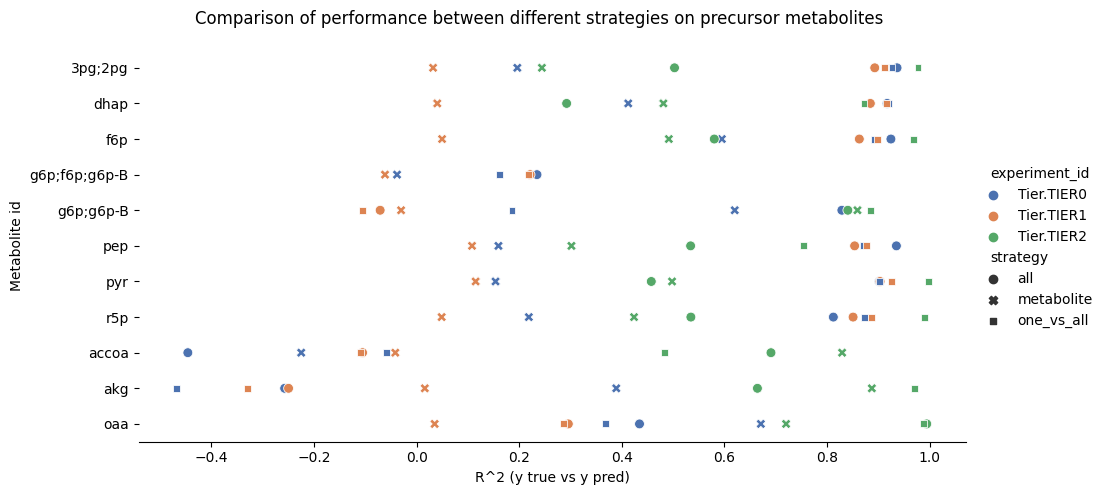

In [12]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
tier_2_results['experiment_id'] = tier_2_results['mode'].apply(lambda x: f"{Tier.TIER2}")
tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'r2'}, axis=1)
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'r2', 'metabolite_id']]
tier_2_results = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['r2'].transform(max) == tier_2_results['r2']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results = tier_2_results.assign(architecture='all')

_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0).reset_index(drop=True)
g = sns.relplot(
    data=_df, 
    style='strategy',
    # kind='strip',
    y='metabolite_id',
    x='r2',
    hue='experiment_id',
    palette='deep',
    # height=4,
    aspect=2,
    # size=12,
    s=50,
    # legend=False,
)
g.despine(left=True)
# g.set(yscale='symlog')

# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    ylabel='Metabolite id',
    xlabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

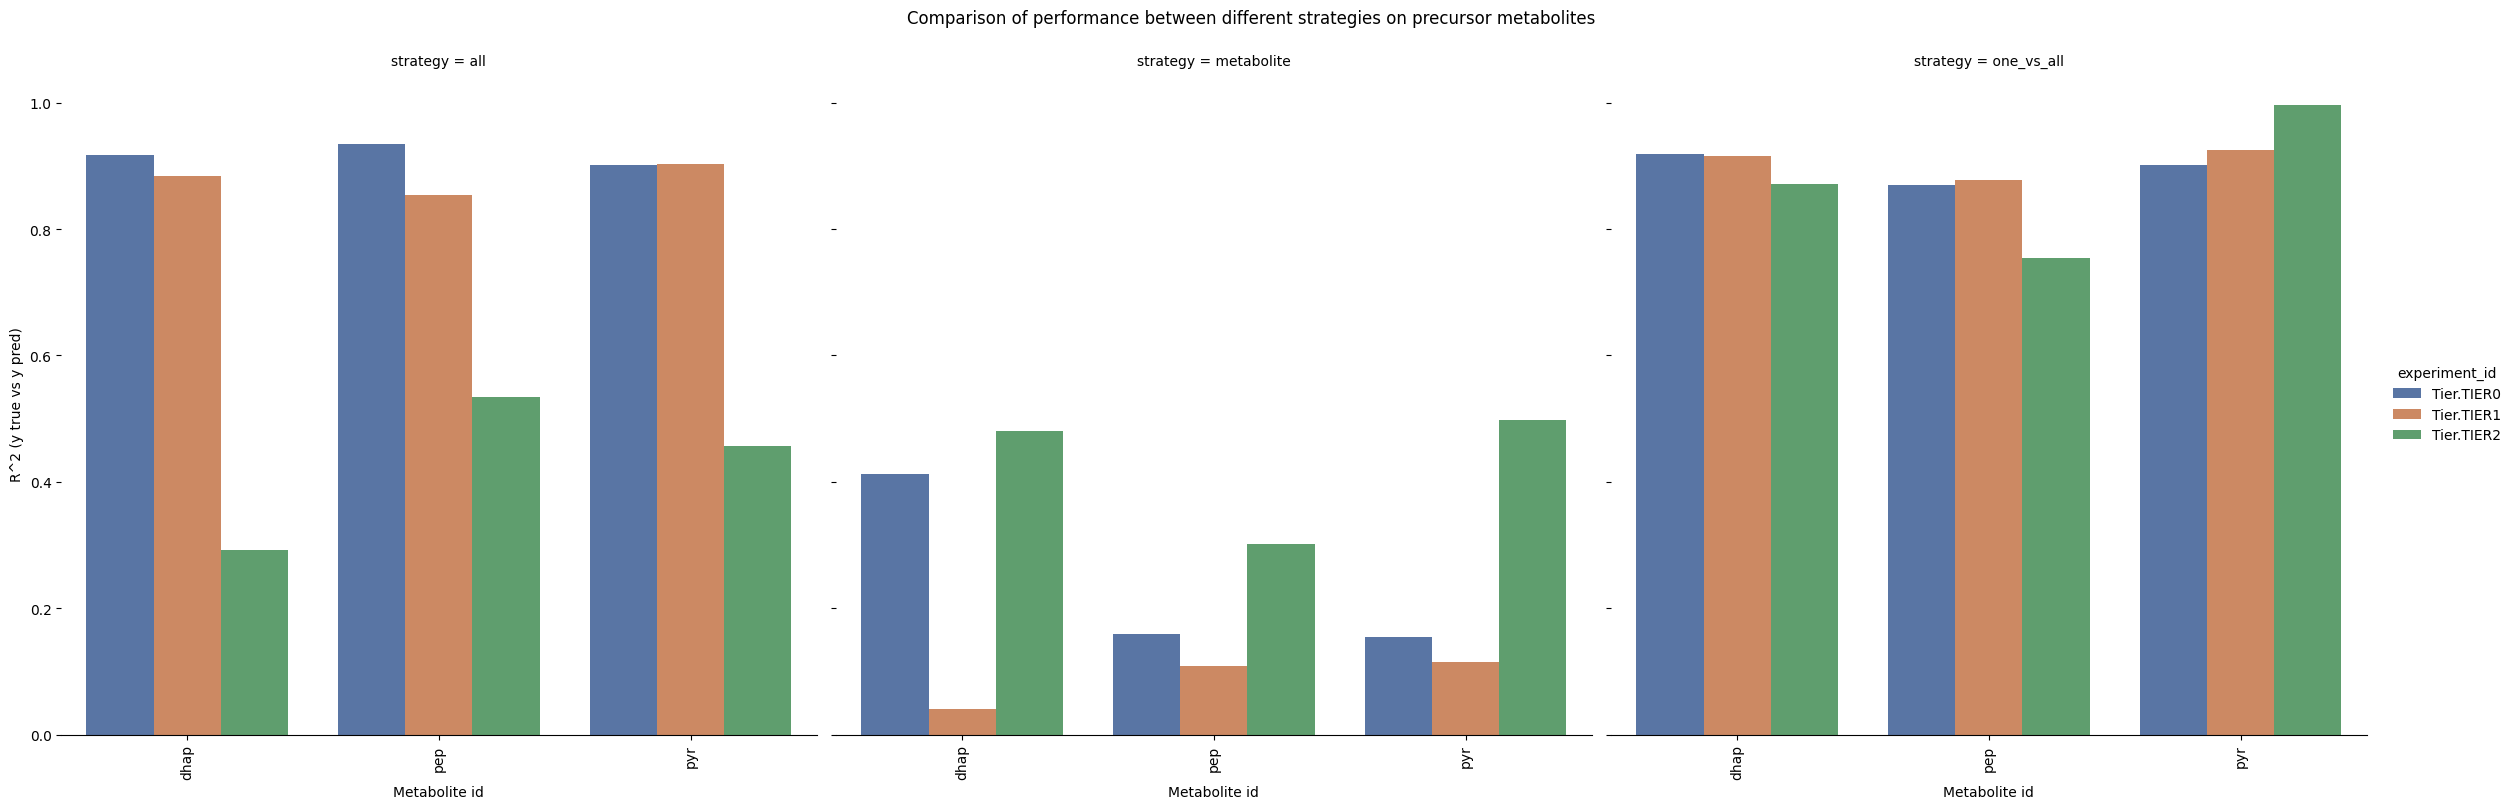

In [13]:
_df = test_df_arch_all.sort_values(['pathway', 'metabolite_id'])
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0)
_df = _df[_df['metabolite_id'].isin(['dhap', 'pep', 'pyr'])]
g = sns.catplot(
    data=_df, 
    col='strategy',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='experiment_id',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

In [14]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
# tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'r2'}, axis=1)
tier_2_results['architecture'] = tier_2_results['mode'].apply(lambda x: f"GAT_{x.replace('metabolite_gnn_sweep_full_', '')}()")
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'r2', 'metabolite_id', 'architecture']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results['experiment_id'] = Tier.TIER2
tier_2_results

,experiment_id,strategy,r2,metabolite_id,architecture,official_name,kegg_id,pathway,method,Order
0,Tier.TIER2,Strategy.ONE_VS_ALL,0.811178,f6p,GAT_strict(),D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
1,Tier.TIER2,Strategy.ONE_VS_ALL,0.701284,f6p,GAT_strict(),D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
2,Tier.TIER2,Strategy.ONE_VS_ALL,0.835975,f6p,GAT_strict(),D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
3,Tier.TIER2,Strategy.ONE_VS_ALL,0.893891,f6p,GAT_strict(),D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
4,Tier.TIER2,Strategy.ONE_VS_ALL,0.812117,f6p,GAT_strict(),D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
...,...,...,...,...,...,...,...,...,...,...
1099,Tier.TIER2,Strategy.ALL,-0.047612,pep,GAT_all(),Phosphoenolpyruvate,C00074,Glycolysis,TCA,7
1100,Tier.TIER2,Strategy.ALL,0.450446,pep,GAT_all(),Phosphoenolpyruvate,C00074,Glycolysis,TCA,7
1101,Tier.TIER2,Strategy.ALL,0.105881,pep,GAT_all(),Phosphoenolpyruvate,C00074,Glycolysis,TCA,7
1102,Tier.TIER2,Strategy.ALL,0.000000,pep,GAT_all(),Phosphoenolpyruvate,C00074,Glycolysis,TCA,7


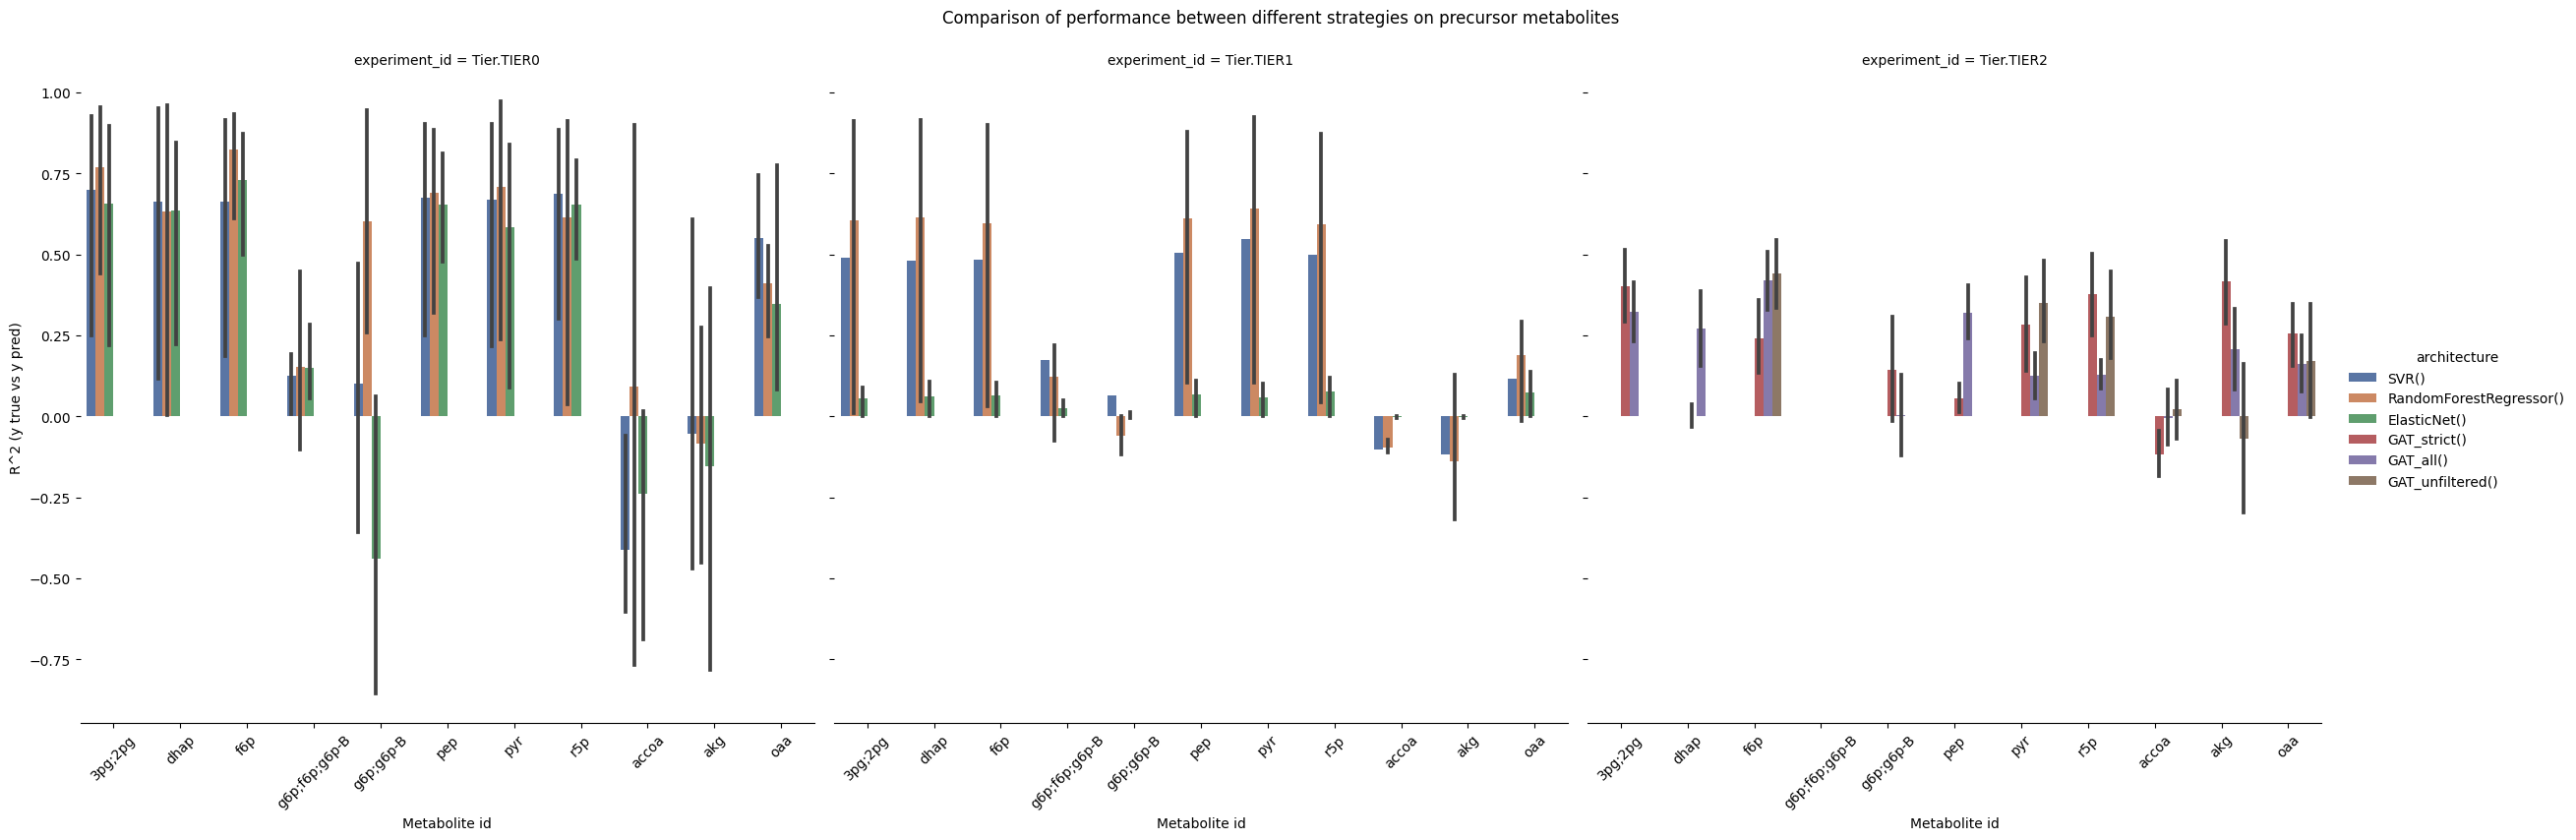

In [15]:
_df = test_df_arch_per_model.sort_values(['pathway', 'metabolite_id'])
_df = pd.concat([_df, tier_2_results])
g = sns.catplot(
    data=_df, 
    col='experiment_id',
    kind='bar',
    x='metabolite_id',
    y='r2',
    hue='architecture',
    palette='deep',
    height=8,
)
g.despine(left=True)
# g.set(yscale='symlog')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    xlabel='Metabolite id',
    ylabel="R^2 (y true vs y pred)"
)

plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.png', bbox_inches='tight')
plt.savefig('./images/performance/comparison_between_different_strategies_using_optimal_model.svg', bbox_inches='tight')

# Accuracy metric

In [16]:
import itertools

tiers = [Tier.TIER0, Tier.TIER1]
strategies = [Strategy.ALL, Strategy.METABOLITE_CENTRIC, Strategy.ONE_VS_ALL]

def get_best_model_performance(tier, strategy):
    root_dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results"
    test_pred_df = pd.read_json(
        f'{root_dir}/{tier}/best_model_prediction_performance_{strategy}.json'
    )
    test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
        .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
        .explode(['y_true', 'y_pred']).assign(strategy=strategy).assign(tier=tier)
    return test_pred_df

test_pred_df = pd.concat([get_best_model_performance(tier, strategy) for tier, strategy in itertools.product(tiers, strategies)])
test_pred_df

,y_true,y_pred,architecture,metabolite_id,correlation,official_name,kegg_id,pathway,method,Order,strategy,tier
1,-0.202798,0.073673,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,-0.460057,-0.700664,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,1.017077,0.677271,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,0.064741,0.775579,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
1,0.424999,0.626765,all,pyr,0.901648,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0
...,...,...,...,...,...,...,...,...,...,...,...,...
32,0.90805,0.263041,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1
32,0.90805,0.248887,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1
32,0.90805,0.284728,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1
32,0.90805,0.293192,ElasticNet(),r5p,0.114854,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1


/tmp/ipykernel_1618/3378052730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')


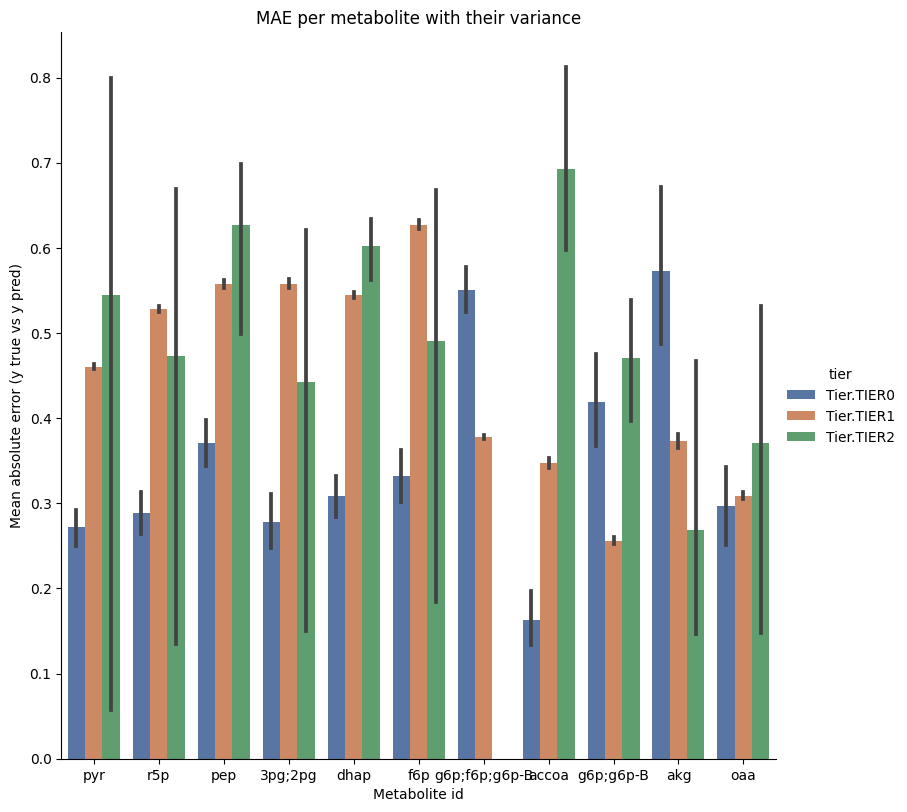

In [17]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
# tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.Mean absolute error': 'error'}, axis=1)
tier_2_results['architecture'] = tier_2_results['mode'].apply(lambda x: f"GAT_{x.replace('metabolite_gnn_sweep_full_', '')}()")
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'error', 'metabolite_id', 'architecture']]
tier_2_results = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['error'].transform(min) == tier_2_results['error']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results['tier'] = Tier.TIER2
# tier_2_results = tier_2_results.assign(architecture='all')

_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0)

g = sns.catplot(
    data=_df, 
    # col='tier',
    kind='bar',
    x='metabolite_id',
    y='error',
    hue='tier',
    palette='deep',
    height=8,
)

axes = g.figure.axes

# axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
g.set(xlabel="Metabolite id", ylabel="Mean absolute error (y true vs y pred)", title="MAE per metabolite with their variance")
# plt.tight_layout()

In [33]:
_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = abs(_df['y_true'].values - _df['y_pred'].values)
print(_df)
_df = _df.groupby(['architecture', 'metabolite_id', 'strategy', 'tier'])['error'].mean()
_df

      y_true    y_pred  architecture metabolite_id correlation  \
13 -0.634193 -0.148054         SVR()           pyr     0.88793   
13  0.896245  0.685571         SVR()           pyr     0.88793   
13  0.573175  0.511698         SVR()           pyr     0.88793   
13  1.011987     0.684         SVR()           pyr     0.88793   
13  0.779453  0.766518         SVR()           pyr     0.88793   
..       ...       ...           ...           ...         ...   
32   0.90805  0.263041  ElasticNet()           r5p    0.114854   
32   0.90805  0.248887  ElasticNet()           r5p    0.114854   
32   0.90805  0.284728  ElasticNet()           r5p    0.114854   
32   0.90805  0.293192  ElasticNet()           r5p    0.114854   
32   0.90805  0.262678  ElasticNet()           r5p    0.114854   

                 official_name kegg_id     pathway method  Order  \
13                    Pyruvate  C00022  Glycolysis    TCA      8   
13                    Pyruvate  C00022  Glycolysis    TCA      8   
13 

/tmp/ipykernel_1618/1328099757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = abs(_df['y_true'].values - _df['y_pred'].values)


TypeError: '<' not supported between instances of 'Strategy' and 'Strategy'

In [18]:
tier_2_results = pd.read_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
# tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.Mean absolute error': 'error'}, axis=1)
tier_2_results['architecture'] = tier_2_results['mode'].apply(lambda x: f"GAT_{x.replace('metabolite_gnn_sweep_full_', '')}()")
tier_2_results = tier_2_results[['experiment_id', 'strategy', 'error', 'metabolite_id', 'architecture']]
tier_2_results = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['error'].transform(min) == tier_2_results['error']]

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results['tier'] = Tier.TIER2
# tier_2_results = tier_2_results.assign(architecture='all')

_df = test_pred_df[test_pred_df['architecture'] != 'all']
_df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')
_df = pd.concat([_df, tier_2_results.reset_index(drop=True)], axis=0)

/tmp/ipykernel_1618/14323936.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['error'] = mean_absolute_error(_df['y_true'].values.reshape(1, -1), _df['y_pred'].values.reshape(1, -1), multioutput='raw_values')


In [19]:
_df

,y_true,y_pred,architecture,metabolite_id,correlation,official_name,kegg_id,pathway,method,Order,strategy,tier,error,experiment_id
13,-0.634193,-0.148054,SVR(),pyr,0.88793,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,0.486140,NaN
13,0.896245,0.685571,SVR(),pyr,0.88793,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,0.210674,NaN
13,0.573175,0.511698,SVR(),pyr,0.88793,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,0.061477,NaN
13,1.011987,0.684,SVR(),pyr,0.88793,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,0.327987,NaN
13,0.779453,0.766518,SVR(),pyr,0.88793,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,0.012935,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,NaN,NaN,GAT_strict(),f6p,NaN,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,Strategy.ALL,Tier.TIER2,0.621065,5.531437e+17
39,NaN,NaN,GAT_unfiltered(),f6p,NaN,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2,Strategy.ONE_VS_ALL,Tier.TIER2,0.183740,5.531437e+17
40,NaN,NaN,GAT_all(),r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER2,0.669700,5.531437e+17
41,NaN,NaN,GAT_all(),r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ALL,Tier.TIER2,0.613626,5.531437e+17


KeyboardInterrupt: 

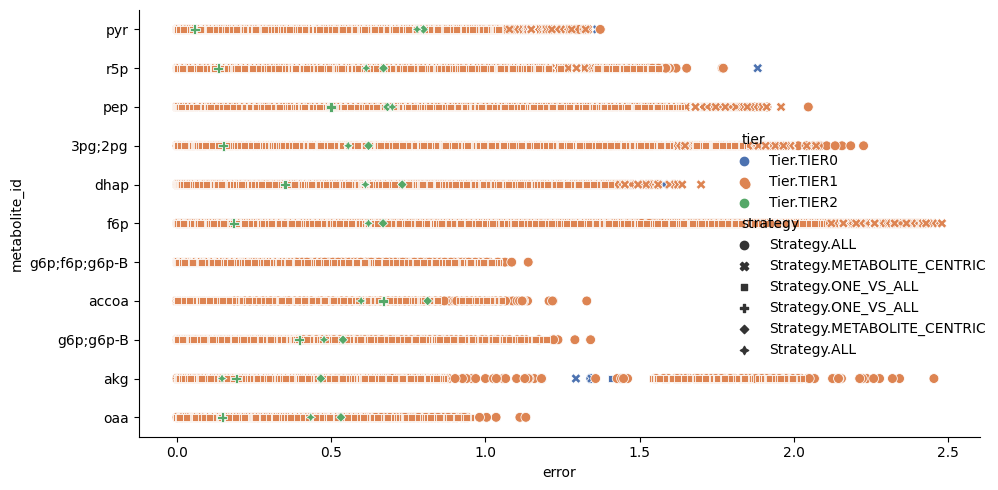

In [20]:


g = sns.relplot(
    data=_df, 
    style='strategy',
    # kind='strip',
    y='metabolite_id',
    x='error',
    hue='tier',
    palette='deep',
    # height=4,
    aspect=2,
    # size=12,
    s=50,
    # legend=False,
)
g.despine(left=True)
# g.set(yscale='symlog')

# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Comparison of performance between different strategies on precursor metabolites')

g.set(
    # title='Comparison of performance between different strategies on precursor metabolites',
    ylabel='Metabolite id',
    xlabel="R^2 (y true vs y pred)"
)

# Explanation

In [21]:
import glob

root_dir = "/home/tijmen/tudelft/thesis/metaengineering"
strategy = Strategy.ALL
tier = Tier.TIER0

tiers = [Tier.TIER0, Tier.TIER1]
strategies = [Strategy.ALL, Strategy.METABOLITE_CENTRIC, Strategy.ONE_VS_ALL]

def get_lime_explanations(tier, strategy):
    def get_frame(path, metabolite_id):
        explanation_df = pd.read_json(path) \
            .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
            .assign(strategy=strategy).assign(tier=tier).assign(frame_id=metabolite_id)
        return explanation_df

    root_dir = "/home/tijmen/tudelft/thesis/metaengineering/"
    paths = glob.glob(f"{root_dir}/explanation/{tier}/lime/{strategy}_*.json")
    metabolite_ids = [path.rsplit('/', 1)[1].removesuffix('.json').removeprefix(f'{strategy}_') for path in paths]
    print(paths)
    print(metabolite_ids)
    print(f'{root_dir}/explanation/{tier}/lime/{strategy}_all.json')
    explanation_df = pd.concat([get_frame(path, metabolite_id) for path, metabolite_id in zip(paths, metabolite_ids)])
        
    
    return explanation_df

explanation_df = pd.concat([get_lime_explanations(tier, strategy) for tier, strategy in itertools.product(tiers, strategies)])
explanation_df

['/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.ALL_all.json']
['all']
/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.ALL_all.json
['/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_f6p.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_g6p;f6p;g6p-B.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_oaa.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_r5p.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_akg.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_dhap.json', '/home/tijmen/tudelft/thesis/metaengineering//explanation/Tier.TIER0/lime/Strategy.METABOLITE_CENTRIC_g6p;g6

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred,official_name,kegg_id,pathway,method,Order,strategy,tier,frame_id
0,YBR059C,pyr,"[YER012W, YGR254W, YPL262W, YML008C, YGR001C, ...","[-0.0308304737, 0.0254235911, 0.0226005415, -0...",0.844023,0.831159,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
1,YPL141C,pyr,"[YER012W, YGR254W, YLR438W, YGR175C, YPL262W, ...","[-0.0352542928, 0.030518200800000003, 0.026307...",0.039513,-0.249019,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
4,YDR490C,pyr,"[YER012W, YGR254W, YML008C, YPL262W, YGR175C, ...","[-0.0376251138, 0.0301763853, -0.0251105116, 0...",0.028086,-0.478923,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
15,YGL179C,pyr,"[YER012W, YGR254W, YLR438W, YGR175C, YPL262W, ...","[-0.035160843000000004, 0.0294499134, 0.026419...",0.533595,0.799462,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
27,YPL236C,pyr,"[YER012W, YLR438W, YGR175C, YML008C, YPL262W, ...","[-0.0387017017, 0.0260341038, -0.0250271360000...",0.580472,0.729733,Pyruvate,C00022,Glycolysis,TCA,8,Strategy.ALL,Tier.TIER0,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9123,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.011256954500000001, -0.0097476184, -0.0069...",0.261479,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p
9124,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.0112566064, -0.009747349800000001, -0.0069...",0.249941,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p
9125,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.0112569029, -0.0097475089, -0.006939211000...",0.273099,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p
9126,YJL141C,r5p,"[interaction_2, interaction_16, interaction_24...","[-0.0112570575, -0.0097476698, -0.006939438500...",0.279312,0.908050,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.ONE_VS_ALL,Tier.TIER1,r5p


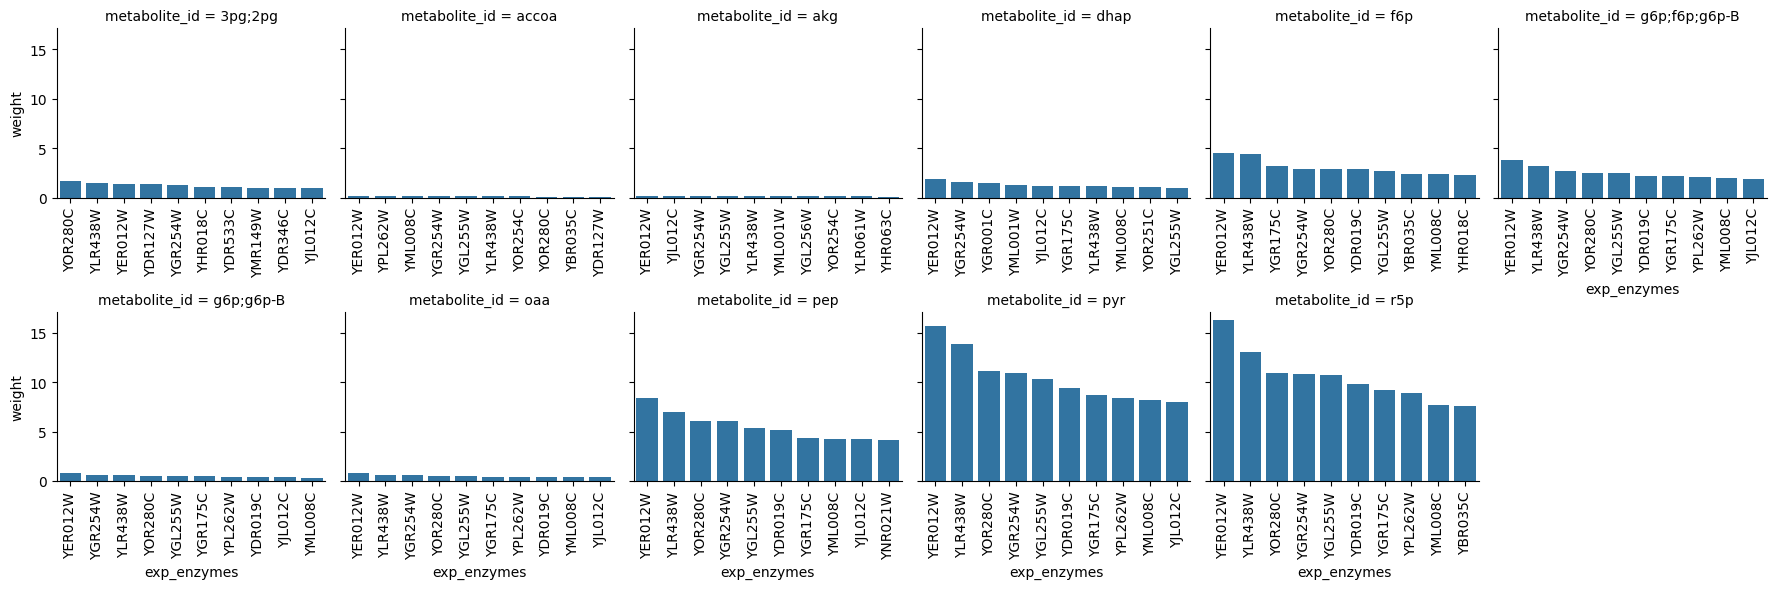

In [22]:
_df = explanation_df[explanation_df['tier'] == Tier.TIER0].explode(['exp_enzymes', 'exp_weights']).groupby(by=['metabolite_id', 'exp_enzymes'])['exp_weights'].sum().abs() \
    .to_frame('weight').reset_index() \
    .groupby('metabolite_id').apply(lambda x: x.sort_values(by='weight', ascending=False).head(10))

g = sns.FacetGrid(data=_df, col='metabolite_id', col_wrap=6, sharex=False)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='weight')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

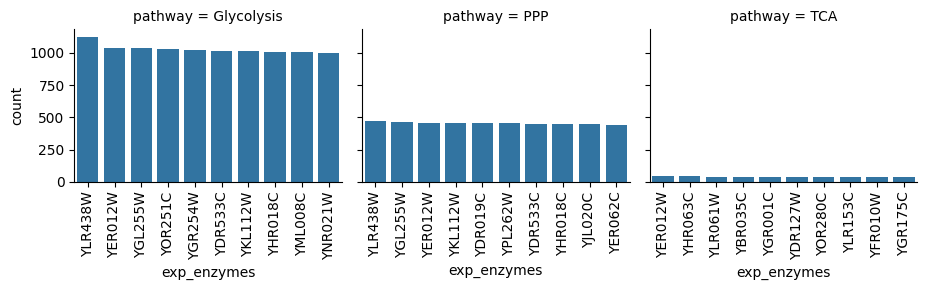

In [23]:
_df = explanation_df[explanation_df['tier'] == Tier.TIER0].explode(['exp_enzymes', 'exp_weights']) \
    .groupby(['pathway', 'exp_enzymes'])['KO_ORF'].count().to_frame('count').reset_index() \
    .groupby('pathway', as_index=False).apply(lambda x: x.sort_values(by='count', ascending=False).head(10)) \
    
_df = _df.merge(
    right=explanation_df.groupby('pathway').size().to_frame('total'),
    left_on='pathway',
    right_on='pathway'
)
# _df['percentage'] = _df['count'] / _df['total']

g = sns.FacetGrid(data=_df, col='pathway', col_wrap=6, sharex=False, sharey=True)
g.map_dataframe(sns.barplot, x='exp_enzymes', y='count')

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()